In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
data_dir = "digital_wallet_transactions.csv"

In [190]:
df = pd.read_csv(data_dir, parse_dates=['transaction_date'])
df.head(3)

,idx,transaction_id,user_id,transaction_date,product_category,product_name,merchant_name,product_amount,transaction_fee,cashback,loyalty_points,payment_method,transaction_status,merchant_id,device_type,location
0,1,4dac3ea3-6492-46ec-80b8-dc45c3ad0b14,USER_05159,2023-08-19 03:32:00,Rent Payment,2BHK Flat Deposit,Airbnb,1525.39,36.69,19.19,186,Debit Card,Successful,MERCH_0083,iOS,Urban
1,2,a903ed9f-eb84-47e7-b8aa-fd1786c919cf,USER_07204,2023-08-19 04:37:00,Gas Bill,Commercial Gas Connection,Adani Gas,1495.40,28.19,89.99,182,UPI,Successful,MERCH_0163,iOS,Urban
2,3,2a393013-733c-4add-9f09-bed1eeb33676,USER_00903,2023-08-19 05:52:00,Bus Ticket,Semi-Sleeper,MakeMyTrip Bus,1267.71,11.36,95.70,994,UPI,Successful,MERCH_0320,iOS,Urban


In [204]:
weekly_transactions = df.groupby(df['transaction_date'].dt.to_period('W')).size().reset_index(name='transaction_count')
monthly_transactions = df.groupby(df['transaction_date'].dt.to_period('M')).size().reset_index(name='transaction_count')

#  Active Users & Count of transactions per user

Text(0.5, 1.0, 'Weekly Transactions Activity')

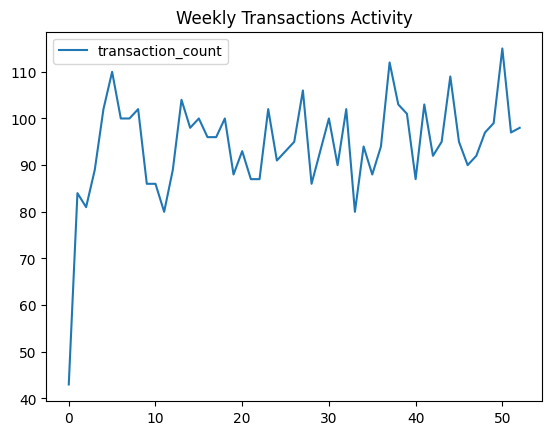

In [13]:
sns.lineplot( data=weekly_transactions)  # weekly transactions activity over time
plt.title('Weekly Transactions Activity')

Text(0.5, 1.0, 'Monthly Transactions Activity')

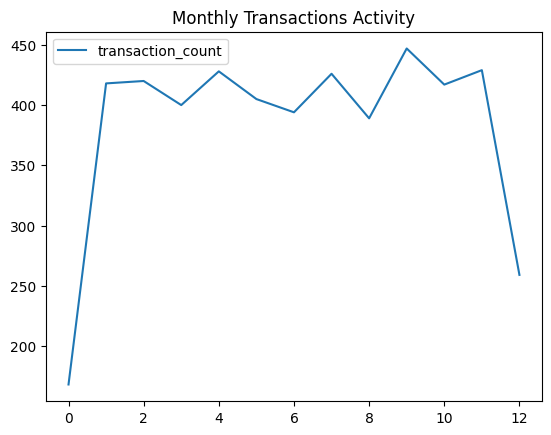

In [206]:
sns.lineplot( data=monthly_transactions)  # weekly transactions activity over time
plt.title('Monthly Transactions Activity')

## Weekly Active users are varying between 80-110 but no exponential improvement overtime

# Users with multiple transactions

In [14]:
user_frequency = df.groupby("user_id").size().reset_index(name='transaction_count')

In [120]:
user_frequency.groupby("transaction_count").size().reset_index(name='user_count').sort_values(by='transaction_count')

,transaction_count,user_count
0,1,3029
1,2,759
2,3,123
3,4,21


## Observation : 3000 users out of 5000 total transactions are one time customers which indicates high churn risk

# Identifying Repeat Users

In [68]:
target_min_repetition = 2
repeat_users = user_frequency[user_frequency['transaction_count']  >= target_min_repetition]["user_id"].values

In [193]:
repeat_user_data = df[df['user_id'].isin(repeat_users)]
repeat_user_data.head(3)

,idx,transaction_id,user_id,transaction_date,product_category,product_name,merchant_name,product_amount,transaction_fee,cashback,loyalty_points,payment_method,transaction_status,merchant_id,device_type,location
6,7,89df83e5-98d3-4c0f-b273-59b0d057fc34,USER_05280,2023-08-19 07:15:00,Hotel Booking,Villa,Treebo,6688.17,49.62,22.18,58,UPI,Successful,MERCH_0441,Android,Urban
7,8,1a8ab910-657a-4e57-90ec-90420290e8a1,USER_03459,2023-08-19 07:57:00,Gas Bill,Piped Natural Gas,Adani Gas,1802.28,0.11,14.56,950,UPI,Successful,MERCH_0938,iOS,Urban
9,10,19c7d2d5-8566-42ba-95aa-8d803cfeeffd,USER_07264,2023-08-19 10:01:00,Insurance Premium,Term Life Policy,Max Life,2207.90,45.70,21.87,129,Wallet Balance,Successful,MERCH_0245,iOS,Urban


<Axes: xlabel='location', ylabel='count'>

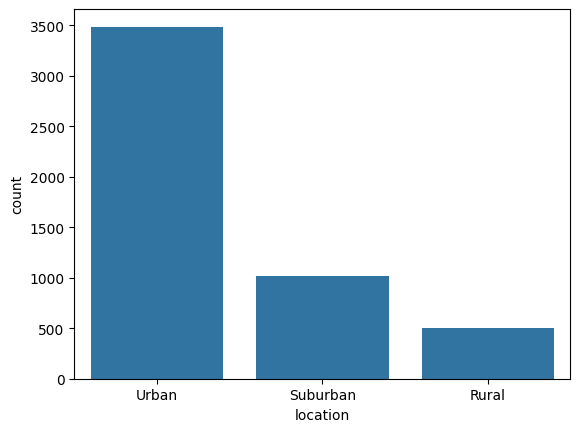

In [195]:
sns.countplot(x="location", data=df)  # Repeat user product category distribution

In [139]:
# Group by location for both dataframes
repeat_counts = repeat_user_data.groupby('location')['user_id'].nunique().reset_index(name='repeat_count')
total_users = df.groupby('location')['user_id'].nunique().reset_index(name='total_count')

# Merge on location
merged = pd.merge(repeat_counts, total_counts, on='location', how='left')

# Calculate percentage
merged['repeat_percentage'] = (merged['repeat_count'] / merged['total_count']) * 100
merged[['location', 'repeat_percentage']].sort_values(by='repeat_percentage', ascending=False)

,location,repeat_percentage
0,Rural,35.140562
1,Suburban,33.824975
2,Urban,23.758967


In [201]:
average_order_value_of_repeated_users = repeat_user_data.groupby('user_id')['product_amount'].mean().reset_index(name='average_order_value')
average_order_value_of_repeated_users

,user_id,average_order_value
0,USER_00019,2709.490000
1,USER_00028,3833.450000
2,USER_00032,4653.055000
3,USER_00051,5034.336667
4,USER_00061,4336.585000
...,...,...
898,USER_09951,5188.115000
899,USER_09963,2969.550000
900,USER_09964,4839.505000
901,USER_09968,7862.965000


Repeat customers are high in rural areas compared to urban areas, play with number of target_min_repetition rate to understand more about each frequency

In [ ]:
unsuccessful_transactions_of_repeat_users.groupby('payment_method')['transaction_status'].value_counts().unstack().fillna(0)

# Understanding onetime user behaviour

In [74]:
single_transaction_users = user_frequency[user_frequency['transaction_count'] == 1]["user_id"].values

In [75]:
single_user_data = df[df['user_id'].isin(single_transaction_users)]

<Axes: xlabel='count', ylabel='location'>

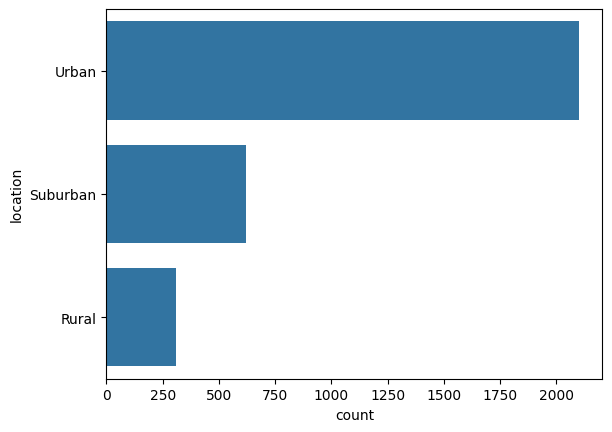

In [76]:
sns.countplot(y="location", data=single_user_data, order=single_user_data['location'].value_counts().index)  # Single transaction users by location

In [150]:
single_user_data.groupby('payment_method')['user_id'].nunique().reset_index(name='payment_count').sort_values(by='payment_count', ascending=False)

,payment_method,payment_count
2,Debit Card,641
0,Bank Transfer,618
1,Credit Card,608
3,UPI,608
4,Wallet Balance,554


In [203]:
unsuccessful_transactions_of_single_users = single_user_data[single_user_data['transaction_status'] != "Successful"]
unsuccessful_transactions_of_single_users.head(3)

,idx,transaction_id,user_id,transaction_date,product_category,product_name,merchant_name,product_amount,transaction_fee,cashback,loyalty_points,payment_method,transaction_status,merchant_id,device_type,location
82,83,e204f872-24c1-4cd3-a98e-313027c7dd03,USER_05459,2023-08-23 20:10:00,Loan Repayment,Home Loan EMI,SBI,4527.36,44.44,43.92,771,Debit Card,Failed,MERCH_0086,Android,Urban
113,114,0417b394-5ecb-4b8f-b47d-4a5083857e09,USER_09924,2023-08-26 02:13:00,Grocery Shopping,Basmati Rice,Grofers,1142.21,35.62,42.15,124,Wallet Balance,Failed,MERCH_0943,Android,Urban
147,148,e99bf8ee-33fc-4a26-9337-2fb212e2bbec,USER_01234,2023-08-29 20:22:00,Streaming Service,Premium Plan,Netflix,5324.86,44.27,50.04,525,UPI,Failed,MERCH_0118,Android,Rural


In [148]:
unsuccessful_transactions_of_single_users.groupby('payment_method')['transaction_status'].value_counts().unstack().sort_values(by='Pending', ascending=False)

transaction_status,Failed,Pending
payment_method,,
Credit Card,20,17
Wallet Balance,15,13
UPI,17,13
Bank Transfer,17,10
Debit Card,20,4


### Most of the unsuccessful transactions for single users are coming from credit card(More in case of pending)

In [124]:
device_data_of_unsuccessful_transactions = unsuccessful_transactions_of_single_users.groupby('device_type')['transaction_status'].value_counts().unstack().fillna(0)


In [138]:
device_data_of_unsuccessful_transactions["Overall"] = device_data_of_unsuccessful_transactions["Failed"]+ device_data_of_unsuccessful_transactions["Pending"]
total_transactions = df.groupby('device_type').size().reset_index(name='total_count')
device_data_of_unsuccessful_transactions = device_data_of_unsuccessful_transactions.merge(total_transactions, on='device_type', how='left')
#device_data_of_unsuccessful_transactions["percentage"] = (device_data_of_unsuccessful_transactions["Overall"] / df.groupby("device_type")['transaction_status'].) * 100

In [ ]:
device_data_of_unsuccessful_transactions.drop(columns=['Failed', 'Pending'], inplace=True)

,device_type,Failed,Pending,Overall,total_count_x,total_count_y
0,Android,46,33,79,3,2995
1,Web,12,6,18,3,479
2,iOS,31,18,49,3,1526


# Understanding Product Metrics

In [155]:
total_productwise_cost = df.groupby('product_category')['product_amount'].sum().reset_index(name='total_cost')

In [157]:
total_productwise_cost.sort_values(by='total_cost', ascending=False, inplace=True)

In [161]:
average_order_value_productwise = df.groupby('product_category')['product_amount'].mean().reset_index(name='average_order_value')

In [171]:
order_count_productwise = df.groupby('product_category')['user_id'].nunique().reset_index(name='order_count')

In [176]:
order_count_productwise.sort_values(ascending=False,by = "order_count", inplace=True)

In [177]:
product_category_metrics  = pd.merge(average_order_value_productwise,order_count_productwise,on = 'product_category',how='left')

In [179]:
product_category_metrics = pd.merge(product_category_metrics, total_productwise_cost, on='product_category', how='left')

In [191]:
product_category_metrics.sort_values(by='total_cost', ascending=False, inplace=True)
product_category_metrics.reset_index(drop=True, inplace=True)
product_category_metrics.head(10)

,product_category,average_order_value,order_count,total_cost
0,Streaming Service,4891.176120,295,1462461.66
1,Water Bill,5130.655128,271,1400668.85
2,Gas Bill,5446.079200,247,1361519.80
3,Education Fee,4717.908287,283,1349321.77
4,Movie Ticket,4916.911360,270,1337399.89
5,Hotel Booking,4816.072628,268,1319603.90
6,Food Delivery,5085.352162,259,1317106.21
7,Taxi Fare,5103.774375,253,1306566.24
8,Rent Payment,5013.002749,247,1258263.69
9,Internet Bill,5352.695579,228,1247178.07
